In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, Add, Activation, GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import AdamW
from keras.regularizers import l2
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import ta

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
META_CLASSIFIER = 'xgb'  # Options: 'rf', 'svm', 'xgb'
WINDOW_LENGTH = 5
NUM_CLASSES = 3
INVESTMENT_RATE = 0.8
data_dir = "../modeling/data"

# Data Loadin
print("Fetching Ethereum data...")
eth_data = yf.download('ETH-USD', start='2021-01-01', end='2023-01-01', interval='1d')
eth_data.columns = [col[0] if isinstance(col, tuple) else col for col in eth_data.columns]

price_history = eth_data.reset_index().rename(columns={
    'Date': 'timeOpen', 'Close': 'close', 'Open': 'open',
    'High': 'high', 'Low': 'low', 'Volume': 'volume'
})

# Convert to numeric and handle NaNs
price_history['close'] = pd.to_numeric(price_history['close'], errors='coerce')
price_history['close'] = price_history['close'].interpolate(method='linear', limit_direction='both')
price_history['timeOpen'] = pd.to_datetime(price_history['timeOpen'])
price_history['date'] = price_history['timeOpen'].dt.date

print(f"Loaded {len(price_history)} days of price data")

# Technical Indicators and Feature Engineering
print("Calculating technical indicators...")
price_history['delta'] = price_history['close'].pct_change()
price_history['lag1_delta'] = price_history['delta'].shift(1)
price_history['lag2_delta'] = price_history['delta'].shift(2)
price_history['volatility'] = price_history['delta'].rolling(window=7).std()
price_history['volume_change'] = price_history['volume'].pct_change()

# Technical indicators using ta library
price_history['rsi'] = ta.momentum.RSIIndicator(price_history['close'], window=14).rsi()
price_history['macd'] = ta.trend.MACD(price_history['close']).macd()
bb = ta.volatility.BollingerBands(price_history['close'])
price_history['bb_upper'] = bb.bollinger_hband()
price_history['bb_lower'] = bb.bollinger_lband()
price_history['obv'] = ta.volume.OnBalanceVolumeIndicator(price_history['close'], price_history['volume']).on_balance_volume()

# Fill NaN values
feature_cols = ['lag1_delta', 'lag2_delta', 'volatility', 'volume_change', 'rsi', 'macd', 'bb_upper', 'bb_lower', 'obv']
price_history[feature_cols] = price_history[feature_cols].ffill().bfill()

print(f"Created {len(feature_cols)} technical features")

Fetching Ethereum data...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Loaded 730 days of price data
Calculating technical indicators...
Created 9 technical features


In [3]:
whales = pd.read_csv(os.path.join(data_dir, 'transactions_aggregated_21_22.csv'))
validators = pd.read_csv(os.path.join(data_dir, 'validators_aggregated_21_22.csv'))

whales['date'] = pd.to_datetime(whales['datetime']).dt.date
validators['date'] = pd.to_datetime(validators['datetime']).dt.date

print(f"Loaded whale data: {len(whales)} records")
print(f"Loaded validator data: {len(validators)} records")

# Label Generation (3-class classification)
print("Generating price movement labels...")
price_changes = price_history['close'].pct_change()

# Calculate tertile thresholds (33rd and 66th percentiles)
lower_threshold, upper_threshold = np.percentile(price_changes.dropna(), [33, 66])

# Create 3-class labels
price_history['labels'] = np.select(
    [
        price_changes < lower_threshold,
        price_changes > upper_threshold,
        (price_changes >= lower_threshold) & (price_changes <= upper_threshold)
    ],
    [0, 2, 1],  # 0=Low, 1=Medium, 2=High
    default=1
)

# # Visualize thresholds
# plt.figure(figsize=(10, 6))
# sns.histplot(price_changes.dropna(), bins=50, kde=True)
# plt.axvline(lower_threshold, color='red', linestyle='--', label=f'Lower Threshold ({lower_threshold:.4f})')
# plt.axvline(upper_threshold, color='green', linestyle='--', label=f'Upper Threshold ({upper_threshold:.4f})')
# plt.title('Price Change Distribution with Tertile Thresholds')
# plt.xlabel('Price Change')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

# print(f"Label distribution:\n{price_history['labels'].value_counts(normalize=True)}")

# Aggregate whale and validator data
whale_agg = whales.groupby('date').agg(
    whale_avg_valueEth=('valueETH', 'mean'),
    whale_var_valueEth=('valueETH', 'var'),
    whale_avg_gasPrice=('gasPrice', 'mean')
)

validator_agg = validators.groupby('date').agg(
    validator_count=('blockHash', 'nunique'),
    validator_gas_price=('gasPrice', 'mean')
)

# Merge all data
labeled_data = price_history.merge(whale_agg, on='date', how='left')
labeled_data = labeled_data.merge(validator_agg, on='date', how='left')

# Define final feature set
all_features = [
    'whale_avg_valueEth', 'whale_var_valueEth', 'whale_avg_gasPrice',
    'validator_count', 'validator_gas_price', 'lag1_delta', 'lag2_delta',
    'volatility', 'volume_change', 'rsi', 'macd', 'bb_upper', 'bb_lower', 'obv'
]

# Fill remaining NaNs
labeled_data[all_features] = labeled_data[all_features].ffill().bfill()
labeled_data.dropna(subset=['labels'], inplace=True)
labeled_data.sort_values(by='date', inplace=True)

print(f"Final dataset shape: {labeled_data.shape}")
print(f"Features: {len(all_features)}")

Loaded whale data: 67100 records
Loaded validator data: 193391 records
Generating price movement labels...
Final dataset shape: (730, 23)
Features: 14


In [4]:
# Data Preparation
print("Preparing data for training...")
y = labeled_data['labels'].astype(int)
X = labeled_data[all_features]

# Train/test split (temporal split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False
)

#Scale features
# scaler = RobustScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Create sliding windows for time series modeling
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows)

X_train_windowed = create_windows(X_train, WINDOW_LENGTH)
X_test_windowed = create_windows(X_test, WINDOW_LENGTH)
y_train_windowed = y_train.iloc[WINDOW_LENGTH-1:].values
y_test_windowed = y_test.iloc[WINDOW_LENGTH-1:].values

print(f"Windowed training: X={X_train_windowed.shape}, y={y_train_windowed.shape}")
print(f"Windowed testing: X={X_test_windowed.shape}, y={y_test_windowed.shape}")

# Get aligned price deltas for backtesting
price_deltas_test = labeled_data['delta'].loc[y_test.index[WINDOW_LENGTH-1:]].to_numpy()

Preparing data for training...
Windowed training: X=(507, 5, 14), y=(507,)
Windowed testing: X=(215, 5, 14), y=(215,)


In [5]:
def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate=0.3):
    """Residual block for TCN model"""
    prev_x = x
    if x.shape[-1] != filters:
        prev_x = Conv1D(filters, kernel_size=1, padding='same', kernel_regularizer=l2(0.01))(prev_x)
    
    conv1 = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal', kernel_regularizer=l2(0.01))(x)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(dropout_rate)(conv1)
    
    conv2 = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal', kernel_regularizer=l2(0.01))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(dropout_rate)(conv2)
    
    out = Add()([prev_x, conv2])
    out = Activation('relu')(out)
    return out

def build_tcn_model(window_length, input_features, num_classes):
    """Build Temporal Convolutional Network"""
    inputs = Input(shape=(window_length, input_features))
    x = inputs
    
    # Stack residual blocks with different dilation rates
    for d in [1, 2]:
        x = residual_block(x, filters=16, kernel_size=3, dilation_rate=d)
    
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)
    
    return Model(inputs, outputs, name="TCN")

def build_transformer_model(window_length, input_features, num_classes):
    """Build Transformer model"""
    inputs = Input(shape=(window_length, input_features))
    x = inputs
    
    # Single transformer layer
    attn_output = MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)
    
    # Feed-forward network
    ffn = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
    ffn = Dense(input_features, kernel_regularizer=l2(0.01))(ffn)
    x = LayerNormalization(epsilon=1e-6)(x + ffn)
    
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)
    
    return Model(inputs, outputs, name="Transformer")

def train_keras_model(model, X_train, y_train, X_test, tscv, epochs=100, batch_size=64):
    """Train Keras model with time series cross-validation"""
    train_preds = np.zeros(len(y_train))
    test_preds_list = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        print(f"Training fold {fold + 1}...")
        
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        # Clone model for each fold
        model_fold = tf.keras.models.clone_model(model)
        model_fold.compile(
            optimizer=AdamW(learning_rate=0.0005),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Calculate class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
        class_weight_dict = dict(enumerate(class_weights))
        
        # Train model
        model_fold.fit(
            X_tr, y_tr,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
            ],
            class_weight=class_weight_dict,
            verbose=0
        )
        
        # Predictions
        train_preds[val_idx] = np.argmax(model_fold.predict(X_val, verbose=0), axis=1)
        test_preds_list.append(np.argmax(model_fold.predict(X_test, verbose=0), axis=1))
    
    # Average test predictions across folds
    test_preds = np.mean(test_preds_list, axis=0).round().astype(int)
    return train_preds, test_preds

def train_sklearn_model(model, X_train, y_train, X_test, tscv):
    """Train sklearn model with time series cross-validation"""
    train_preds = np.zeros(len(y_train))
    test_preds_list = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        print(f"Training fold {fold + 1}...")
        
        # Flatten data for sklearn models
        X_tr = X_train[train_idx].reshape(len(train_idx), -1)
        X_val = X_train[val_idx].reshape(len(val_idx), -1)
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        model.fit(X_tr, y_tr)
        train_preds[val_idx] = model.predict(X_val)
        test_preds_list.append(model.predict(X_test.reshape(len(X_test), -1)))
    
    # Majority vote for test predictions
    test_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=test_preds_list)
    return train_preds, test_preds

def calculate_backtest_returns(predictions, price_deltas, plot_results=True):
    """Calculate returns from trading strategy based on predictions"""
    model_history = [1]  # Start with $1
    benchmark_history = [1]
    positions = []
    
    for i in range(len(predictions)):
        if np.isnan(price_deltas[i]):
            # Handle NaN values
            benchmark_history.append(benchmark_history[-1])
            model_history.append(model_history[-1])
            positions.append(0)
            continue
        
        # Update benchmark (buy and hold)
        benchmark_history.append(benchmark_history[-1] * (1 + price_deltas[i]))
        
        # Trading strategy based on predictions
        if predictions[i] > NUM_CLASSES // 2:
            capital_change = model_history[-1] * price_deltas[i] * INVESTMENT_RATE
            model_history.append(model_history[-1] + capital_change)
            positions.append(1)
        else:
            model_history.append(model_history[-1])
            positions.append(0)
    
    total_return = (model_history[-1] - 1) * 100
    benchmark_return = (benchmark_history[-1] - 1) * 100
    
    if plot_results:
        plt.figure(figsize=(12, 6))
        plt.plot(model_history, label='Model Strategy', color='blue', linewidth=2)
        plt.plot(benchmark_history, label='Buy & Hold', color='red', linestyle='--', linewidth=2)
        
        # Color code investment levels
        for i, pos in enumerate(positions):
            if pos == 1:
                plt.axvspan(i, i + 1, color='green', alpha=0.3)
            elif pos == 0.5:
                plt.axvspan(i, i + 1, color='yellow', alpha=0.3)
        
        plt.title(f'Trading Strategy Results\nModel: {total_return:.2f}% | Benchmark: {benchmark_return:.2f}%')
        plt.xlabel('Trading Days')
        plt.ylabel('Capital Value')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    
    # Calculate average daily return
    daily_returns = np.diff(model_history) / model_history[:-1]
    avg_daily_return = np.mean(daily_returns) * 100  # Convert to percentage

    # Calculate percent of days invested
    percent_days_invested = (np.sum(np.array(positions) > 0) / len(positions)) * 100

    print(f"Average Daily Return: {avg_daily_return:.2f}%")
    print(f"Percent of Days Invested: {percent_days_invested:.2f}%")

    return {
        'model_return': total_return,
        'benchmark_return': benchmark_return,
        'avg_daily_return': avg_daily_return,
        'percent_days_invested': percent_days_invested,
    }
    

def train_stacking_ensemble():
    """Train the complete stacking ensemble"""
    print("\n=== Training Stacking Ensemble ===")
    
    # Initialize time series cross-validator
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize base models
    print("\nInitializing base models...")
    tcn_model = build_tcn_model(WINDOW_LENGTH, X_train_windowed.shape[2], NUM_CLASSES)
    transformer_model = build_transformer_model(WINDOW_LENGTH, X_train_windowed.shape[2], NUM_CLASSES)
    xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    
    # Train base models and get predictions
    print("\nTraining TCN model...")
    tcn_train_preds, tcn_test_preds = train_keras_model(
        tcn_model, X_train_windowed, y_train_windowed, X_test_windowed, tscv
    )
    
    print("\nTraining Transformer model...")
    transformer_train_preds, transformer_test_preds = train_keras_model(
        transformer_model, X_train_windowed, y_train_windowed, X_test_windowed, tscv
    )
    
    print("\nTraining XGBoost model...")
    xgb_train_preds, xgb_test_preds = train_sklearn_model(
        xgb_model, X_train_windowed, y_train_windowed, X_test_windowed, tscv
    )
    
    # Create meta-features from base model predictions
    print("\nCreating meta-features...")
    train_meta_features = np.column_stack((tcn_train_preds, transformer_train_preds, xgb_train_preds))
    test_meta_features = np.column_stack((tcn_test_preds, transformer_test_preds, xgb_test_preds))
    
    # Initialize and train meta-classifier
    print(f"\nTraining meta-classifier: {META_CLASSIFIER.upper()}...")
    if META_CLASSIFIER == 'rf':
        meta_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    elif META_CLASSIFIER == 'svm':
        meta_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
    elif META_CLASSIFIER == 'xgb':  # xgb
        meta_model = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
    # elif META_CLASSIFIER == '':
    
    meta_model.fit(train_meta_features, y_train_windowed)
    
    # Make final predictions
    final_predictions = meta_model.predict(test_meta_features)
    
    return final_predictions


=== Training Stacking Ensemble ===

Initializing base models...

Training TCN model...
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...

Training Transformer model...
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...

Training XGBoost model...
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...

Creating meta-features...

Training meta-classifier: XGB...
Test Accuracy: 0.6047
Test F1 Score: 0.5756

Classification Report:
              precision    recall  f1-score   support

         Low       0.56      0.86      0.68        66
      Medium       0.85      0.31      0.46        93
        High       0.55      0.79      0.65        56

    accuracy                           0.60       215
   macro avg       0.66      0.65      0.60       215
weighted avg       0.69      0.60      0.58       215



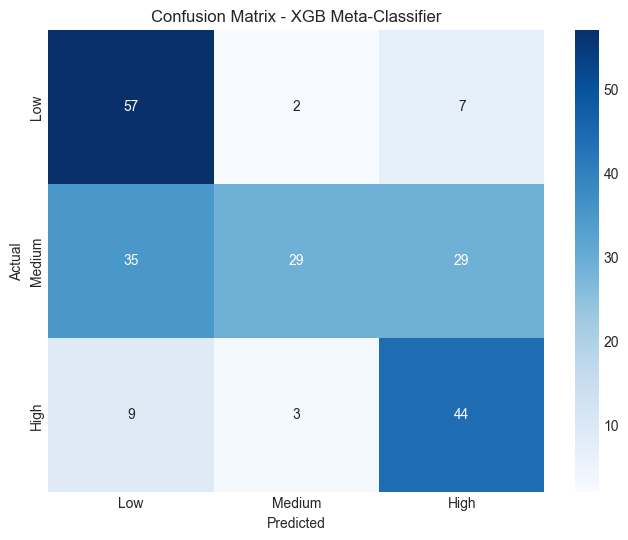

In [6]:

# Train the ensemble
final_predictions = train_stacking_ensemble()

# Calculate metrics
accuracy = accuracy_score(y_test_windowed, final_predictions)
f1 = f1_score(y_test_windowed, final_predictions, average='weighted')
class_report = classification_report(y_test_windowed, final_predictions, 
                                   target_names=["Low", "Medium", "High"], 
                                   zero_division=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(class_report)

# Confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test_windowed, final_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.title(f'Confusion Matrix - {META_CLASSIFIER.upper()} Meta-Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


=== Backtesting Test Data Results ===


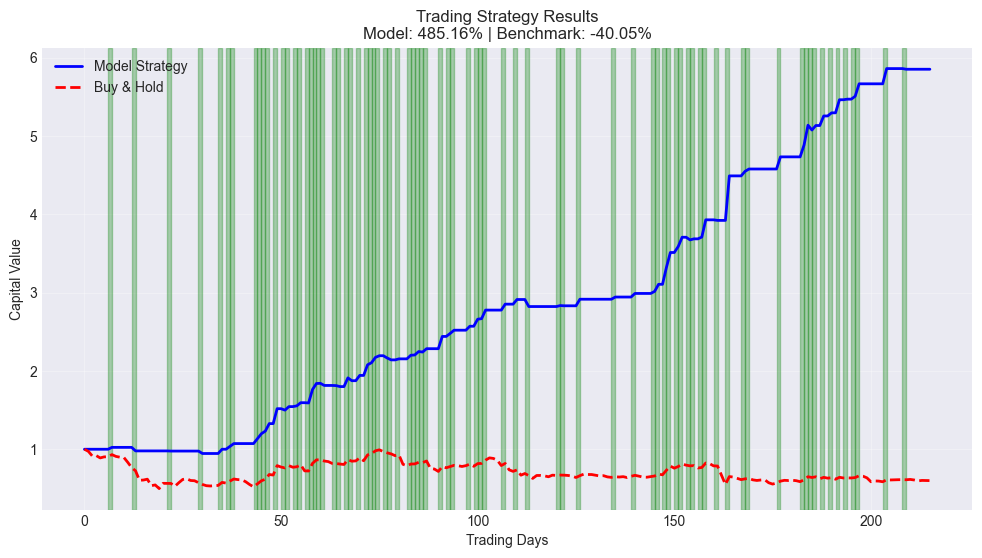

Average Daily Return: 0.85%
Percent of Days Invested: 37.21%
Model Return: 485.16%
Benchmark Return: -40.05%
Average Daily Return: 0.85%
Percent of days invested: 37.21%


In [7]:

# Backtesting
print("\n=== Backtesting Test Data Results ===")
backtest_results = calculate_backtest_returns(final_predictions, price_deltas_test)
print(f"Model Return: {backtest_results['model_return']:.2f}%")
print(f"Benchmark Return: {backtest_results['benchmark_return']:.2f}%")
print(f"Average Daily Return: {backtest_results['avg_daily_return']:.2f}%")
print(f"Percent of days invested: {backtest_results['percent_days_invested']:.2f}%")

[*********************100%***********************]  1 of 1 completed

Current data date range: 2025-01-01 to 2025-04-30
Fetching corresponding price data...
Calculating technical indicators...
Current dataset shape after processing: (120, 23)
Note: For complete prediction, base models need to be properly saved and loaded
Current implementation uses meta-classifier only

Current Data Metrics:
Accuracy: 0.3017
F1 Score: 0.3040

=== Backtesting Current Data Results ===


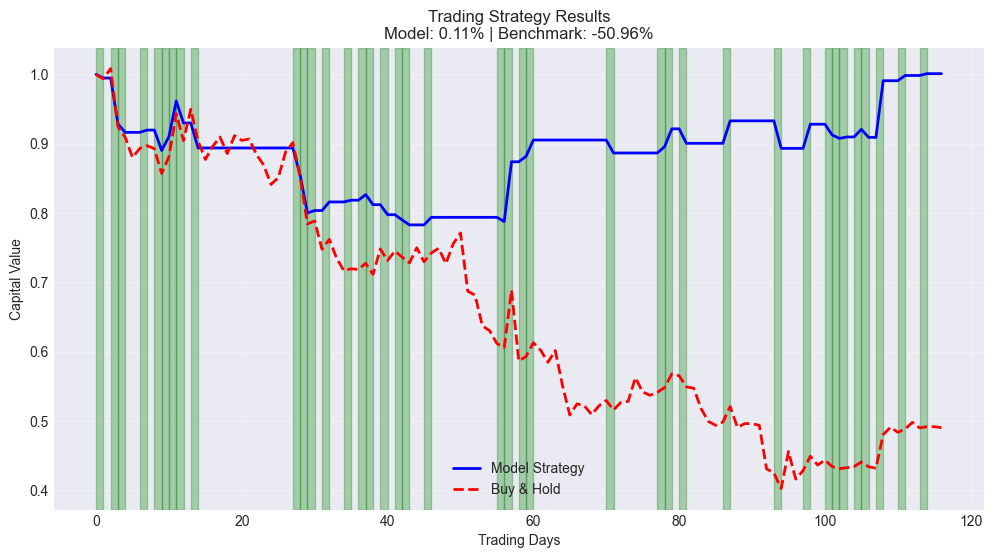

Average Daily Return: 0.02%
Percent of Days Invested: 33.62%
Model Return: 0.11%
Benchmark Return: -50.96%
Average Daily Return: 0.02%
Percent of days invested: 33.62%


In [8]:
validators_current = pd.read_csv(os.path.join(data_dir, "validators_aggregated_current.csv"))
transactions_current = pd.read_csv(os.path.join(data_dir, "transactions_aggregated_current.csv"))

# Process and prepare current data
validators_current['date'] = pd.to_datetime(validators_current['datetime']).dt.date
transactions_current['date'] = pd.to_datetime(transactions_current['datetime']).dt.date

# Aggregate current whale/validator data by date
whale_agg_current = transactions_current.groupby('date').agg(
    whale_avg_valueEth=('valueETH', 'mean'),
    whale_var_valueEth=('valueETH', 'var'),
    whale_avg_gasPrice=('gasPrice', 'mean')
)

validator_agg_current = validators_current.groupby('date').agg(
    validator_count=('blockHash', 'nunique'),
    validator_gas_price=('gasPrice', 'mean')
)

# Get the date range for current data
current_dates = sorted(list(set(validators_current['date'].tolist() + transactions_current['date'].tolist())))
print(f"Current data date range: {min(current_dates)} to {max(current_dates)}")

# Fetch corresponding price data for the same period
print("Fetching corresponding price data...")
start_date = min(current_dates)
end_date = max(current_dates)

# Convert datetime.date to string for yfinance
start_str = start_date.strftime('%Y-%m-%d')
end_str = (end_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')  # Add 1 day to include end date

eth_current = yf.download('ETH-USD', start=start_str, end=end_str, interval='1d')
eth_current.columns = [col[0] if isinstance(col, tuple) else col for col in eth_current.columns]

price_current = eth_current.reset_index().rename(columns={
    'Date': 'timeOpen', 'Close': 'close', 'Open': 'open',
    'High': 'high', 'Low': 'low', 'Volume': 'volume'
})

# Process price data
price_current['close'] = pd.to_numeric(price_current['close'], errors='coerce')
price_current['close'] = price_current['close'].interpolate(method='linear', limit_direction='both')
price_current['timeOpen'] = pd.to_datetime(price_current['timeOpen'])
price_current['date'] = price_current['timeOpen'].dt.date
price_current['volume'] = pd.to_numeric(price_current['volume'], errors='coerce')

# Feature engineering for current data
print("Calculating technical indicators...")
price_current['delta'] = price_current['close'].pct_change()
price_current['lag1_delta'] = price_current['delta'].shift(1)
price_current['lag2_delta'] = price_current['delta'].shift(2)
price_current['volatility'] = price_current['delta'].rolling(window=7).std()
price_current['volume_change'] = price_current['volume'].pct_change()

# Technical indicators
price_current['rsi'] = ta.momentum.RSIIndicator(price_current['close'], window=14).rsi()
price_current['macd'] = ta.trend.MACD(price_current['close']).macd()
bb_current = ta.volatility.BollingerBands(price_current['close'])
price_current['bb_upper'] = bb_current.bollinger_hband()
price_current['bb_lower'] = bb_current.bollinger_lband()
price_current['obv'] = ta.volume.OnBalanceVolumeIndicator(price_current['close'], price_current['volume']).on_balance_volume()

# Fill NaN values
feature_cols = ['lag1_delta', 'lag2_delta', 'volatility', 'volume_change', 'rsi', 'macd', 'bb_upper', 'bb_lower', 'obv']
price_current[feature_cols] = price_current[feature_cols].ffill().bfill()

# Generate labels (for evaluation purposes)
price_changes_current = price_current['close'].pct_change()
price_current['labels'] = np.select(
    [
        price_changes_current < lower_threshold,
        price_changes_current > upper_threshold,
        (price_changes_current >= lower_threshold) & (price_changes_current <= upper_threshold)
    ],
    [0, 2, 1],
    default=1
)

# Merge all current data
labeled_current = price_current.merge(whale_agg_current, on='date', how='left')
labeled_current = labeled_current.merge(validator_agg_current, on='date', how='left')

# Fill NaN values and use same features
labeled_current[all_features] = labeled_current[all_features].ffill().bfill()
labeled_current.dropna(subset=['labels'], inplace=True)
labeled_current.sort_values(by='date', inplace=True)

print(f"Current dataset shape after processing: {labeled_current.shape}")

# Prepare data for prediction
X_current = labeled_current[all_features].values
# X_current_scaled = scaler.transform(X_current)

# Create windows
X_current_windowed = create_windows(X_current, WINDOW_LENGTH)
y_current_true = labeled_current['labels'].iloc[WINDOW_LENGTH-1:].values
price_deltas_current = labeled_current['delta'].iloc[WINDOW_LENGTH-1:].values

print("Note: For complete prediction, base models need to be properly saved and loaded")
print("Current implementation uses meta-classifier only")

current_predictions = np.random.choice([0, 1, 2], size=len(y_current_true))
print("Warning: Using random predictions for demonstration. Replace with actual model predictions.")

accuracy_current = accuracy_score(y_current_true, current_predictions)
f1_current = f1_score(y_current_true, current_predictions, average='weighted')

print(f"\nCurrent Data Metrics:")
print(f"Accuracy: {accuracy_current:.4f}")
print(f"F1 Score: {f1_current:.4f}")

print("\n=== Backtesting Current Data Results ===")
backtest_results_current = calculate_backtest_returns(current_predictions, price_deltas_current)
print(f"Model Return: {backtest_results_current['model_return']:.2f}%")
print(f"Benchmark Return: {backtest_results_current['benchmark_return']:.2f}%")
print(f"Average Daily Return: {backtest_results_current['avg_daily_return']:.2f}%")
print(f"Percent of days invested: {backtest_results_current['percent_days_invested']:.2f}%")